<a href="https://colab.research.google.com/github/Nuhayd12/Coral_Classification_and_Prediction/blob/main/Coral_Health_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

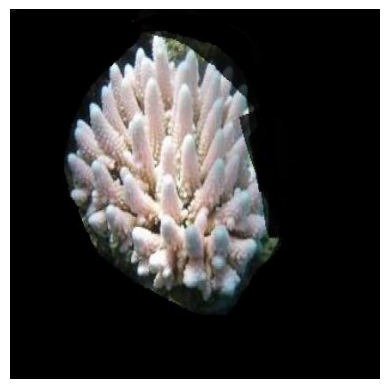

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image path
image_path = '/content/drive/MyDrive/USE/test/Bleached/dup_142_i7yf_JPG.rf.cb7a469a6ad797351d488743a091d9d6.jpg'

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()


# Data generators

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pred_Images/Train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pred_Images/Valid',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pred_Images/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2232 images belonging to 3 classes.
Found 172 images belonging to 3 classes.
Found 86 images belonging to 3 classes.



# Model definition

In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilation

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#**DIGGING THE LAYERS**

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt


#PREPROCESS THE IMAGE

In [12]:
# Load and preprocess the image
image_path = '/content/drive/MyDrive/Pred_Images/Train/bleached/11--2-_jpg.rf.a8a75b97b9ac3fe91a70b0992f7d1443.jpg'
img = load_img(image_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  #Batch dimension

#LIST THE LAYER OUTPUTS

In [13]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the activations

In [14]:
activations = activation_model.predict(img_array)

1/1 [==============================] - 0s 188ms/step


# Function to plot the activations

In [15]:
def plot_layer_activations(activations, layer_names):
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // 16
        display_grid = np.zeros((size * n_cols, size * 16))

        for col in range(n_cols):
            for row in range(16):
                channel_image = layer_activation[0, :, :, col * 16 + row]
                channel_image -= channel_image.mean()
                if channel_image.std() != 0:
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Plot the activations

MemoryError: Unable to allocate 368. TiB for an array with shape (85525504, 591872) and data type float64

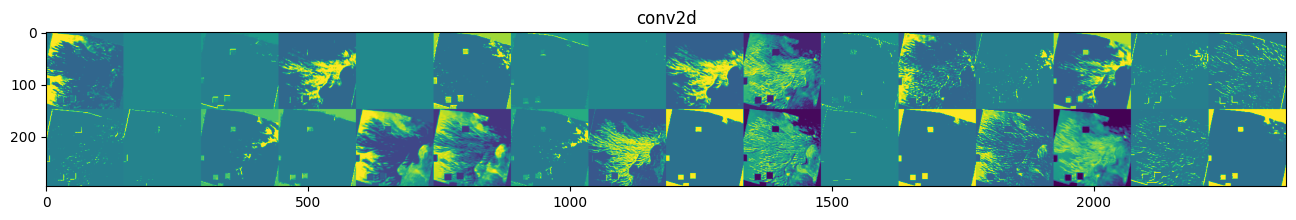

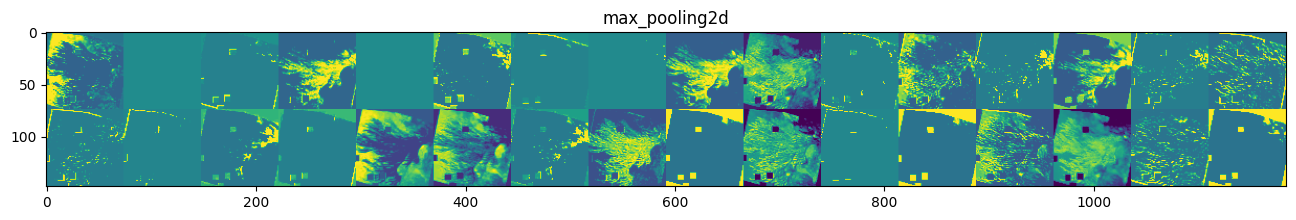

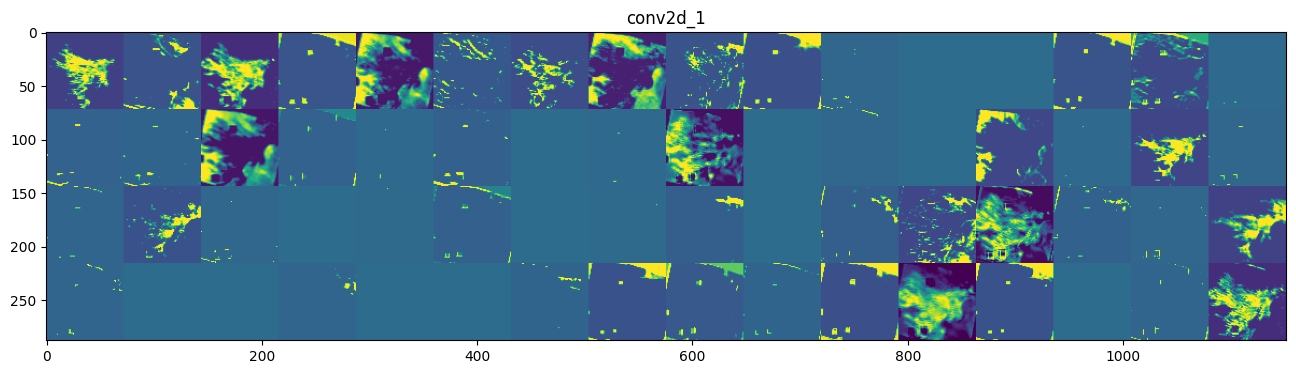

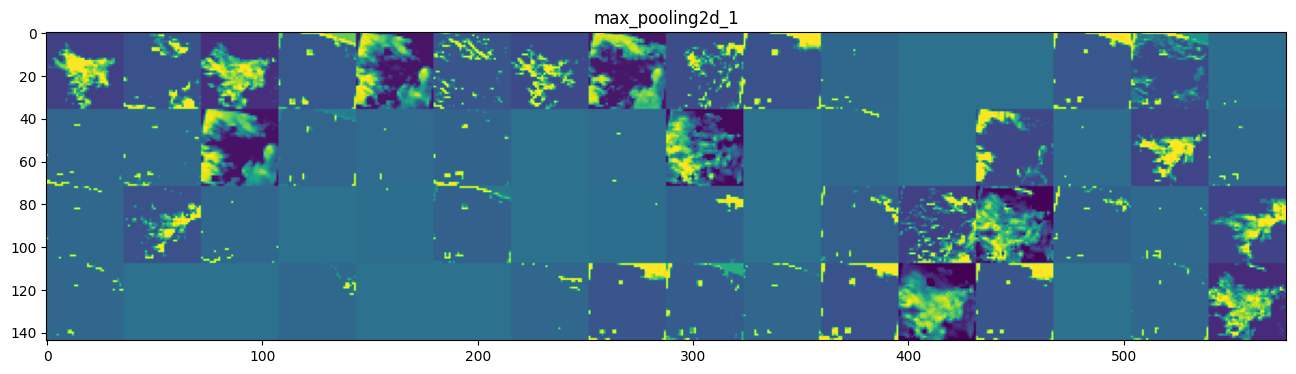

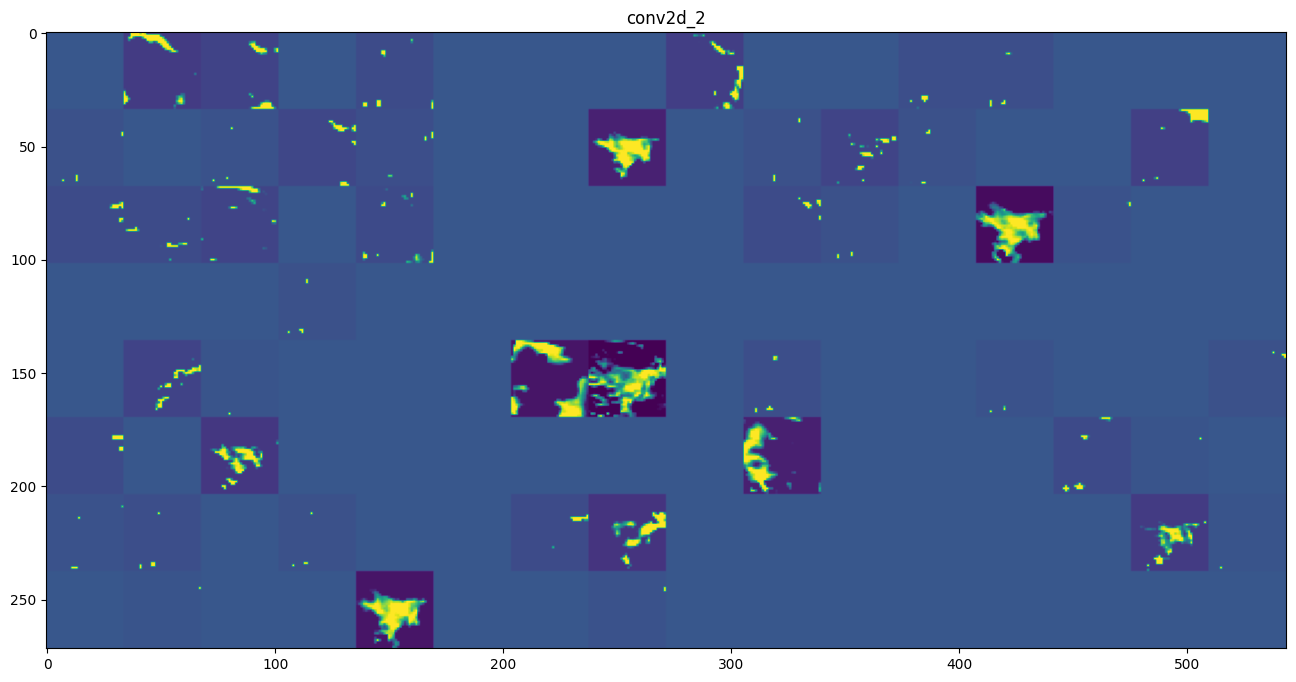

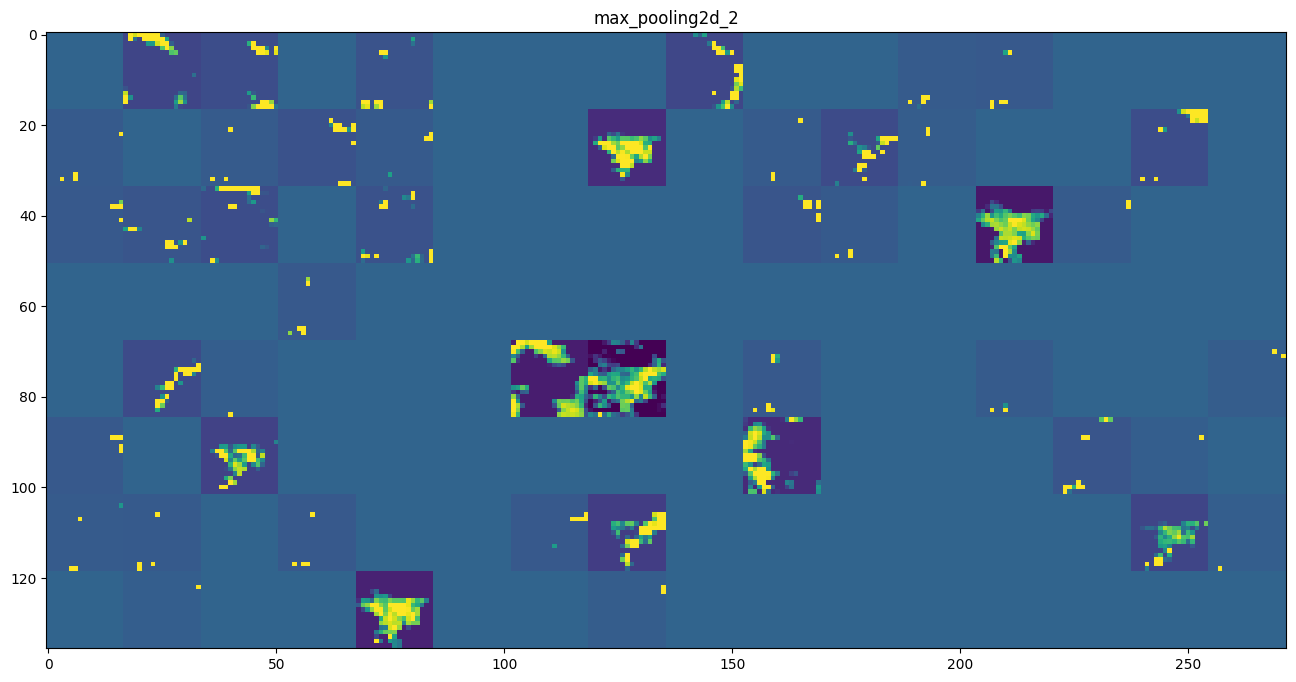

In [16]:
layer_names = [layer.name for layer in model.layers]
plot_layer_activations(activations, layer_names)


# Training

In [6]:
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/70
70/70 [==============================] - 696s 10s/step - loss: 1.0308 - accuracy: 0.5242 - val_loss: 0.9577 - val_accuracy: 0.6279
Epoch 2/70
70/70 [==============================] - 140s 2s/step - loss: 0.7458 - accuracy: 0.6604 - val_loss: 0.6826 - val_accuracy: 0.6744
Epoch 3/70
70/70 [==============================] - 141s 2s/step - loss: 0.6747 - accuracy: 0.7101 - val_loss: 0.5905 - val_accuracy: 0.7442
Epoch 4/70
70/70 [==============================] - 140s 2s/step - loss: 0.6253 - accuracy: 0.7392 - val_loss: 0.6343 - val_accuracy: 0.7267
Epoch 5/70
70/70 [==============================] - 171s 2s/step - loss: 0.6007 - accuracy: 0.7487 - val_loss: 0.5241 - val_accuracy: 0.7965
Epoch 6/70
70/70 [==============================] - 188s 3s/step - loss: 0.5279 - accuracy: 0.7773 - val_loss: 0.5417 - val_accuracy: 0.7907
Epoch 7/70
70/70 [==============================] - 139s 2s/step - loss: 0.5087 - accuracy: 0.7881 - val_loss: 0.4853 - val_accuracy: 0.8081
Epoch 8/70
7

# Evaluation

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

3/3 [==============================] - 23s 11s/step - loss: 0.0841 - accuracy: 0.9651
Test accuracy: 0.9651162624359131


# Predictions and classification report

In [9]:
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)


3/3 [==============================] - 1s 295ms/step


In [10]:
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

    Bleached       0.92      0.96      0.94        25
     Healthy       1.00      1.00      1.00        36
   partially       0.96      0.92      0.94        25

    accuracy                           0.97        86
   macro avg       0.96      0.96      0.96        86
weighted avg       0.97      0.97      0.97        86

[[24  0  1]
 [ 0 36  0]
 [ 2  0 23]]
